In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
from numpy.linalg import inv
%matplotlib inline

In [2]:
data = pd.read_csv("data/Portfolios_Formed_on_INV-2.csv",skiprows=17,index_col=0,parse_dates=True,nrows=691)
data = data.dropna()
data.index = pd.to_datetime(data.index,format="%Y%m")

factors = pd.read_csv("data/F-F_Research_Data_Factors.csv",skiprows=3,index_col=0,parse_dates=True,nrows=1134)
factors = factors.dropna()
factors.index = pd.to_datetime(factors.index,format="%Y%m")
rm = factors["Mkt-RF"]
rf = factors["RF"]

portfolio_25 = pd.read_csv("data/25_Portfolios_5x5.csv",skiprows=15,index_col="DATE",parse_dates=True,nrows=1134)
portfolio_25 = portfolio_25.dropna()
portfolio_25.index = pd.to_datetime(portfolio_25.index,format="%Y%m")

portfolio_25 = portfolio_25["1963-07-01":"2020-06-01"]
data = data["1963-07-01":"2020-06-01"]
rm = rm["1963-07-01":"2020-06-01"]
rf = rf["1963-07-01":"2020-06-01"]
factors = factors["1963-07-01":"2020-06-01"]
ex_data = data.subtract(rf,axis=0)
factors = factors.drop("RF",axis=1)

In [3]:
# b, CAPM for the 10 investment portfolios, plot alphas against investment deciles
alphas = []
betas = []
for i in range(8,18):
    y = ex_data.iloc[:,i]
    x = sm.add_constant(rm)
    res = sm.OLS(y,x,cov_type="HC0").fit()
    alphas.append(res.params[0])
    betas.append(res.params[1])

alphas = pd.DataFrame(alphas).T
alphas.columns = ["Lo 10","Dec 2", "Dec 3","Dec 4","Dec 5", "Dec 6", "Dec 7","Dec 8", "Dec 9", "Hi 10"]
alphas.index = ["Pricing error"]
alphas = alphas.T

In [4]:
alphas

,Pricing error
Lo 10,0.167358
Dec 2,0.233005
Dec 3,0.185294
Dec 4,0.103203
Dec 5,0.090755
Dec 6,0.051453
Dec 7,0.115504
Dec 8,-0.010789
Dec 9,0.022597
Hi 10,-0.321981


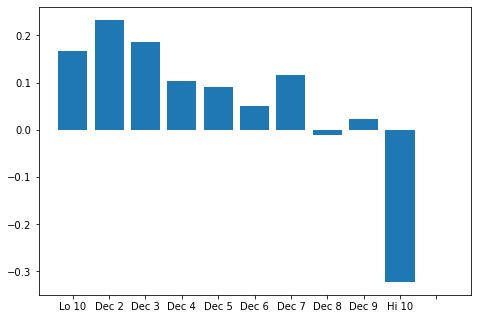

In [5]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ["Lo 10","Dec 2" ,"Dec 3","Dec 4","Dec 5", "Dec 6", "Dec 7","Dec 8", "Dec 9", "Hi 10",""]
a = [alphas.iloc[0],alphas.iloc[1],alphas.iloc[2],alphas.iloc[3],alphas.iloc[4],alphas.iloc[5],alphas.iloc[6],alphas.iloc[7],alphas.iloc[8],alphas.iloc[9],0]
ax.bar(langs,a)
plt.show()


In [6]:
inv_growth = data["Hi 30"] - data["Lo 30"]
factors_inv = factors.copy()
factors_inv["INV"] = inv_growth

In [7]:
def calc_GRS(alpha_vector, factor_dataframe, asset_returns):
    gen_cov = factor_dataframe.cov()
    generalized_sharpe = factor_dataframe.mean().T @ inv(gen_cov) @ factor_dataframe.mean()     #Cochrane 2005, p.217
    cov = asset_returns.cov()
    if isinstance(alpha_vector, list):
        alpha_vector = np.array(alpha_vector)
    #Calc GRS
    df = len(asset_returns) - len(asset_returns.columns) - len(factor_dataframe.columns) # T - N - K     (N = number of assets, K = number of factors)
    N = len(asset_returns.columns)
    GRS = (df/ N) * ((alpha_vector.T @ inv(cov) @ alpha_vector) / (1+ generalized_sharpe))
    p = 1-scipy.stats.f.cdf(GRS, len(asset_returns.columns), df) #find p-value of F test statistic
    return np.round(GRS,2), p

In [8]:
# 3 d

inv_alphas = []
inv_tvalues = []
inv_adj_rsq = []

for column in portfolio_25:
    x = sm.add_constant(factors_inv)
    y = portfolio_25[column]
    res = sm.OLS(y,x,cov_type="HC0").fit()
    inv_alphas.append(res.params[0])
    inv_tvalues.append(res.tvalues)
    inv_adj_rsq.append(res.rsquared_adj)


grs_a = inv_alphas
ff_investment_table = pd.DataFrame(inv_tvalues)
inv_alphas = pd.DataFrame(inv_alphas)
inv_alphas.columns = ["alphas"]
inv_adj_rsq = pd.DataFrame(inv_adj_rsq)
inv_adj_rsq.columns = ["Adjusted R Squared"]
ff_investment_table["Alphas"] = inv_alphas
ff_investment_table["Adjusted R^2"] = inv_adj_rsq
ff_investment_table.columns = ["Alpha tval", "Mkt-RF tval","SMB tval","HML tval", "INV tval","Alphas","Adj R^2"]
ff_investment_table.index = portfolio_25.columns
ff_investment_table

,Alpha tval,Mkt-RF tval,SMB tval,HML tval,INV tval,Alphas,Adj R^2
SMALL LoBM,-0.955953,48.270263,43.399488,-6.260469,1.096222,-0.088237,0.910286
ME1 BM2,5.358494,53.774390,52.342645,1.051935,0.081967,0.394331,0.925893
ME1 BM3,6.677780,72.745816,60.485084,12.927008,-0.350418,0.349972,0.949873
ME1 BM4,10.014632,69.538102,60.964522,20.509297,0.498911,0.516596,0.947335
SMALL HiBM,9.349253,71.336429,58.111123,28.917505,0.946575,0.506306,0.947196
ME2 BM1,2.807352,71.277773,44.746136,-12.553242,-0.831935,0.183423,0.944964
ME2 BM2,6.852061,75.630992,47.736714,2.774268,-3.666211,0.379005,0.944262
ME2 BM3,7.788852,69.442036,37.188519,13.865212,-2.494965,0.448281,0.926285
ME2 BM4,8.430981,78.932095,42.748041,23.939259,-2.722922,0.419781,0.942451
ME2 BM5,6.635245,82.345207,48.454624,33.567033,1.154793,0.354514,0.950579


In [9]:
ff_alphas = []
ff_tvalues = []
ff_adj_rsq = []

for column in portfolio_25:
    x = sm.add_constant(factors)
    y = portfolio_25[column]
    res = sm.OLS(y,x,cov_type="HC0").fit()
    ff_alphas.append(res.params[0])
    ff_tvalues.append(res.tvalues)
    ff_adj_rsq.append(res.rsquared_adj)

grs_b = ff_alphas
ff_table = pd.DataFrame(ff_tvalues)
ff_alphas = pd.DataFrame(ff_alphas)
ff_alphas.columns = ["alphas"]
ff_adj_rsq = pd.DataFrame(ff_adj_rsq)
ff_adj_rsq.columns = ["Adjusted R Squared"]
ff_table["Alphas"] = ff_alphas
ff_table["Adjusted R^2"] = ff_adj_rsq
ff_table.columns = ["Alpha tval", "Mkt-RF tval","SMB tval","HML tval","Alphas","Adj R^2"]
ff_table.index = portfolio_25.columns
ff_table

,Alpha tval,Mkt-RF tval,SMB tval,HML tval,Alphas,Adj R^2
SMALL LoBM,-1.032013,50.311514,43.426278,-8.810059,-0.095055,0.910260
ME1 BM2,5.369088,55.787860,52.394565,1.272987,0.393924,0.926001
ME1 BM3,6.720995,75.337735,60.530411,16.706377,0.351209,0.949938
ME1 BM4,10.009280,72.235789,61.022719,25.676189,0.514862,0.947393
SMALL HiBM,9.307333,74.186772,58.148952,35.994970,0.502852,0.947204
ME2 BM1,2.870584,73.653651,44.748699,-15.298067,0.187086,0.944989
ME2 BM2,7.051066,76.679553,47.239224,6.338362,0.392670,0.943242
ME2 BM3,7.944635,71.010414,37.001899,19.492593,0.457957,0.925719
ME2 BM4,8.593649,80.675414,42.499730,32.390497,0.428917,0.941909
ME2 BM5,6.570757,85.624762,48.478363,41.725143,0.350357,0.950555


In [10]:
# GRS and p values for ff and investment
inv_GRS, inv_p = calc_GRS(grs_a,factors_inv,portfolio_25)
inv_GRS, inv_p

(4.65, 1.8728352202401766e-12)

In [11]:
# GRS and p values for ff alone
ff_GRS, ff_p = calc_GRS(grs_b,factors_inv,portfolio_25)
ff_GRS, ff_p

(4.55, 4.7488679655316446e-12)